# Customer support agent with LangGraph

This agent is designed to categorize customer queries, analyze sentiment, and provide appropriate responses or escalate issues when necessary. The aim of this project is to create a sophisticated support system that can handle a variety of customer inquiries and significantly reduce response times and improve overall customer satisfaction.

**Proposed approach**

1. **State management:** Implement a TypedDict-based framework to consistently track and manage the state of each customer interaction.
2. **Query categorization:** Automatically classify incoming queries into predefined categories—Technical, Billing, or General—for more targeted handling.
3. **Sentiment analysis:** Evaluate the emotional tone of each customer query to guide response style and escalation decisions.
4. **Response generation:** Produce contextually appropriate replies tailored to the determined category and sentiment.
5. **Escalation mechanism:** Seamlessly hand off queries with negative sentiment to human agents for more personalized attention.
6. **Workflow graph:** Leverage LangGraph to construct a dynamic, easily extendable workflow that adapts to various interaction scenarios.

**Conclusion**

This tutorial highlights the power of AI-driven workflows. By combining natural language processing and a structured graph-based approach, we created a versatile customer support agent that can scale, integrate with existing tools, and adapt to diverse, multi-step challenges.

In [1]:
import os
import torch
import pandas as pd
from dotenv import load_dotenv
from typing import Dict, TypedDict
from langchain_community.llms import VLLM
from IPython.display import display, Image
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain.output_parsers import StructuredOutputParser, ResponseSchema

## Set up

In [2]:
# define state structure
class State(TypedDict):
    query: str
    category: str
    language: str
    sentiment: str
    response: str

In [3]:
# get the model
llm = VLLM(
    model="Qwen/Qwen2.5-3B-Instruct-AWQ",
    trust_remote_code=True,  
    max_new_tokens=252,
    top_k=10,
    top_p=0.95,
    temperature=0.1,
    vllm_kwargs={"quantization": "awq"}
)

INFO 12-14 21:29:52 config.py:350] This model supports multiple tasks: {'embedding', 'generate'}. Defaulting to 'generate'.
INFO 12-14 21:29:52 awq_marlin.py:113] Detected that the model can run with awq_marlin, however you specified quantization=awq explicitly, so forcing awq. Use quantization=awq_marlin for faster inference
WARNING 12-14 21:29:52 config.py:428] awq quantization is not fully optimized yet. The speed can be slower than non-quantized models.
INFO 12-14 21:29:52 llm_engine.py:249] Initializing an LLM engine (v0.6.4.post1) with config: model='Qwen/Qwen2.5-3B-Instruct-AWQ', speculative_config=None, tokenizer='Qwen/Qwen2.5-3B-Instruct-AWQ', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.float16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=awq, enforce_e

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 12-14 21:29:54 model_runner.py:1077] Loading model weights took 1.9535 GB
INFO 12-14 21:29:57 worker.py:232] Memory profiling results: total_gpu_memory=15.99GiB initial_memory_usage=3.32GiB peak_torch_memory=4.52GiB memory_usage_post_profile=3.35GiB non_torch_memory=1.39GiB kv_cache_size=8.48GiB gpu_memory_utilization=0.90
INFO 12-14 21:29:58 gpu_executor.py:113] # GPU blocks: 15443, # CPU blocks: 7281
INFO 12-14 21:29:58 gpu_executor.py:117] Maximum concurrency for 32768 tokens per request: 7.54x
INFO 12-14 21:29:58 model_runner.py:1400] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 12-14 21:29:58 model_runner.py:1404] If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utilization` or switching to eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 1

In [4]:
# categorize
def categorize(state: State) -> State:
    """
    Categorize the customer query into Technical, Billing, or General.
    Args:
        state (State): The current state of the query.
    Returns:
        State: The updated state with the query categorized.
    """
    schemas = [
        ResponseSchema(
            name="category", 
            description="The category of the query. Choose from: ['Technical', 'Billing', 'General']"
        ),
        ResponseSchema(
            name="reason", 
            description="The reason the query fits this category"
        )
    ]

    parser = StructuredOutputParser.from_response_schemas(schemas)
    format_instructions = parser.get_format_instructions()

    prompt = ChatPromptTemplate.from_template(
        (
            "Categorize the following customer query: {query}\n"
            "In the 'category' key, include one of the values from this list: ['Technical', 'Billing', 'General'].\n"
            "In the 'reason' key, include the reason why this category is appropriate.\n"
            "Return the answer in JSON format.\n\n"
        )
    ).partial(format_instructions=format_instructions)

    chain = prompt | llm
    response = chain.invoke({"query": state["query"]})
    response = parser.parse(response)
    category = response['category'].lower()

    return {"category": category}

In [5]:
# get language
def detect_language(state: State) -> State:
    """
    Detect the language of the customer's query.
    Args:
        state (State): The current state of the query, containing 'query'.
    Returns:
        State: The updated state with the detected language of the query.
    """
    schemas = [
        ResponseSchema(
            name="language",
            description="The language of the query. For example: 'English' or 'Spanish'"
        ),
        ResponseSchema(
            name="reason",
            description="The reason why the query is identified as this language"
        )
    ]

    parser = StructuredOutputParser.from_response_schemas(schemas)
    format_instructions = parser.get_format_instructions()

    prompt = ChatPromptTemplate.from_template(
        (
            "Detect the language used in the following query: {query}\n"
            "In the 'language' key, identify the language. For example: 'English' or 'Spanish'.\n"
            "In the 'reason' key, explain how you identified the language.\n"
            "Return the answer in JSON format.\n\n"
        )
    ).partial(format_instructions=format_instructions)

    chain = prompt | llm
    response = chain.invoke({"query": state["query"]})
    response = parser.parse(response)
    language = response['language'].lower()

    return {"language": language}

In [6]:
# get sentiment
def get_sentiment(state: State) -> State:
    """
    Analyze the sentiment of the customer query as Positive, Neutral, or Negative.
    Args:
        state (State): The current state containing the query.
    Returns:
        State: The updated state with the query categorized by sentiment.
    """
    schemas = [
        ResponseSchema(
            name="sentiment",
            description="The category of the query: Choose from: ['Positive', 'Neutral', or 'Negative']"
        ),
        ResponseSchema(
            name="reason",
            description="The reason the query fits this sentiment"
        )
    ]

    parser = StructuredOutputParser.from_response_schemas(schemas)
    format_instructions = parser.get_format_instructions()

    prompt = ChatPromptTemplate.from_template(
        (
            "Analyze the sentiment of the following customer query: {query}.\n"
            "In the 'sentiment' key, include one of the values from this list: ['Positive', 'Neutral', or 'Negative'].\n"
            "In the 'reason' key, include the reason why this sentiment is appropriate.\n"
            "Return the answer in JSON format.\n\n"
        )
    ).partial(format_instructions=format_instructions)

    chain = prompt | llm
    response = chain.invoke({"query": state["query"]})
    response = parser.parse(response)
    sentiment = response["sentiment"].lower()

    return {"sentiment": sentiment}

In [7]:
# handle technical
def handle_technical(state: State) -> State:
    """
    Generate a technical support response to a customer query.
    Args:
        state (State): The current state containing the query.
    Returns:
        State: The updated state with the generated technical support response.
    """
    schemas = [
        ResponseSchema(
            name="response",
            description="Answer to the query"
        ),
    ]

    parser = StructuredOutputParser.from_response_schemas(schemas)
    format_instructions = parser.get_format_instructions()

    prompt = ChatPromptTemplate.from_template(
        (
            "Provide a technical support response in {language} to the following query: {query}.\n"
            "Return JSON with key 'response'.\n\n"
        )
    ).partial(format_instructions=format_instructions)

    chain = prompt | llm
    # Invoke chain and get the result object
    result = chain.invoke({"query": state['query'], 'language':state["language"]})
    result = parser.parse(result)
    response = result['response']
    
    return {"response": response}

In [8]:
# handle billing
def handle_billing(state: State) -> State:
    """
    Generate a billing support response to a customer query.
    Args:
        state (State): The current state containing the query.
    Returns:
        State: The updated state with the generated billing support response.
    """
    schemas = [
        ResponseSchema(
            name="response",
            description="Answer to the query"
        ),
    ]

    parser = StructuredOutputParser.from_response_schemas(schemas)
    format_instructions = parser.get_format_instructions()

    prompt = ChatPromptTemplate.from_template(
        (
            "Provide a billing support response in {language} to the following query: {query}.\n"
            "Return JSON with key 'response'.\n\n"
        )
    ).partial(format_instructions=format_instructions)

    chain = prompt | llm
    # Invoke chain and get the result object
    result = chain.invoke({"query": state['query'], 'language':state["language"]})
    result = parser.parse(result)
    response = result['response']
    
    return {"response": response}

In [9]:
# handle general
def handle_general(state: State) -> State:
    """
    Generate a general support response to a customer query.
    Args:
        state (State): The current state containing the query.
    Returns:
        State: The updated state with the generated general support response.
    """
    schemas = [
        ResponseSchema(
            name="response",
            description="Answer to the query"
        ),
    ]

    parser = StructuredOutputParser.from_response_schemas(schemas)
    format_instructions = parser.get_format_instructions()

    prompt = ChatPromptTemplate.from_template(
        (
            "Provide a general support response in {language} to the following query: {query}.\n"
            "Return JSON with key 'response'.\n\n"
        )
    ).partial(format_instructions=format_instructions)

    chain = prompt | llm
    # Invoke chain and get the result object
    result = chain.invoke({"query": state['query'], 'language':state["language"]})
    result = parser.parse(result)
    response = result['response']
    
    return {"response": response}

In [10]:
# escalate
def escalate(state: State) -> State:
    """
    Escalate the query to a human agent due to negative sentiment.
    Args:
        state (State): The current state of the query.
    Returns:
        State: A dictionary containing the escalation response.
    """
    if state["language"] == 'english':
        return {
            "response": (
                "This query has been escalated to a human agent due to its negative sentiment."
            )
        }
    else:
        return {
            "response": (
                "Esta consulta ha sido escalada a un integrante de nuestro equipo dado el sentimiento negativo."
            )
        }        

In [11]:
# query routing
def route_query(state: State) -> str:
    """
    Route the query based on its sentiment and category.
    Args:
        state (State): The current state of the query containing sentiment and category.
    Returns:
        str: The name of the handler function to process the query.
    """

    if state["sentiment"] == "negative":
        return "escalate"
    if state["category"] == "technical":
        return "handle_technical"
    if state["category"] == "billing":
        return "handle_billing"

    return "handle_general"

## Create and configure the graph

In [12]:
# represents the workflow as a directed graph. Each node in the graph corresponds to a specific state or operation, 
# and edges define transitions between these states.
workflow = StateGraph(State)

# each node represents a function that processes the current state and performs a specific operation.
workflow.add_node("categorize", categorize)
workflow.add_node("detect_language", detect_language)
workflow.add_node("analyze_sentiment", get_sentiment)
workflow.add_node("handle_technical", handle_technical)
workflow.add_node("handle_billing", handle_billing)
workflow.add_node("handle_general", handle_general)
workflow.add_node("escalate", escalate)

# add a direct edge between "categorize" and "analyze_sentiment", meaning once the categorize node finishes 
# execution, the workflow transitions to analyze_sentiment.
workflow.add_edge("categorize", "detect_language")
workflow.add_edge("detect_language", "analyze_sentiment")

# the mapping defines possible routes from "analyze_sentiment" to the corresponding nodes 
# ("handle_technical", "handle_billing", "handle_general", or "escalate").
workflow.add_conditional_edges(
    "analyze_sentiment",
    route_query,
    {
        "handle_technical": "handle_technical",
        "handle_billing": "handle_billing",
        "handle_general": "handle_general",
        "escalate": "escalate"
    }
)

# each handling function ("handle_*") and escalation ("escalate") leads to the end of the workflow.
workflow.add_edge("handle_technical", END)
workflow.add_edge("handle_billing", END)
workflow.add_edge("handle_general", END)
workflow.add_edge("escalate", END)

# set entry point, specifies the starting node of the workflow
workflow.set_entry_point("categorize")

# compile the graph
app = workflow.compile()

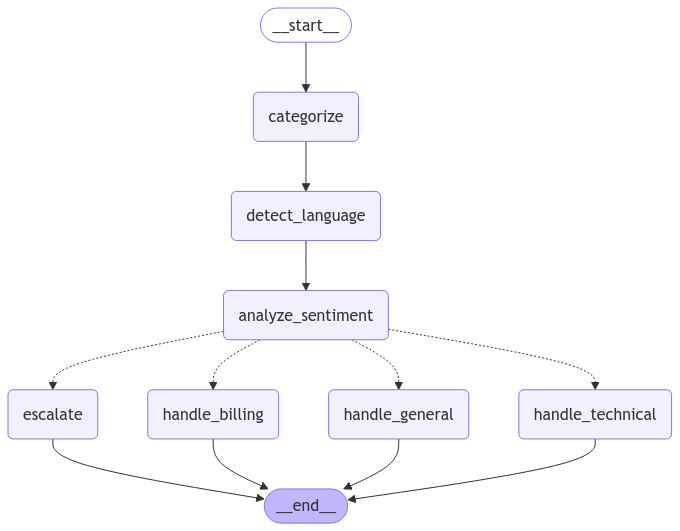

In [13]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Bring the agent to life

In [14]:
def customer_support_agent(query: str) -> Dict[str, str]:
    """Process a customer query through the LangGraph workflow.
    Args:
        query (str): The customer's query
    Returns:
        Dict[str, str]: A dictionary containing the query's category, sentiment, and response
    """
    results = app.invoke({"query": query})
    return {
        "query": query,
        "language": results["language"],
        "category": results["category"],
        "sentiment": results["sentiment"],
        "response": results["response"]
    }

### Testing the agent

#### General inquiries

In [15]:
queries = [
    "Hi, I have a few questions about renewing my domain name. Could you help me understand the renewal process?",
    "Hola, tengo algunas preguntas sobre la renovación de mi dominio. ¿Podrían ayudarme a entender el proceso de renovación?",
    "I'd like to know which hosting plan would be best for my small blog. Can you recommend one?",
    "Me gustaría saber qué plan de alojamiento sería mejor para mi pequeño blog. ¿Podrían recomendarme uno?",
    "Could you provide more information about your website builder's features?",
    "¿Podrían darme más información sobre las características de su creador de sitios web?",
    "I have questions about transferring my domain to another registrar. Can you provide the steps?",
    "Tengo preguntas sobre cómo transferir mi dominio a otro registrador. ¿Podrían proporcionarme los pasos?",
    "I'm happy with the service so far, but I want to add more storage to my hosting plan. Could you assist me?",
    "Estoy satisfecho con el servicio hasta ahora, pero quiero añadir más espacio de almacenamiento a mi plan de alojamiento. ¿Podrían ayudarme?"
]

In [16]:
results = [customer_support_agent(query) for query in queries]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it, est. speed input: 41.70 toks/s, output: 115.76 toks/s]


In [17]:
pd.DataFrame(results)

,query,language,category,sentiment,response
0,"Hi, I have a few questions about renewing my d...",english,billing,neutral,"Certainly! To renew your domain name, you typi..."
1,"Hola, tengo algunas preguntas sobre la renovac...",spanish,billing,neutral,"¡Claro, estaré encantado de ayudarte con tu co..."
2,I'd like to know which hosting plan would be b...,english,general,neutral,"Sure, for a small blog, I recommend checking o..."
3,Me gustaría saber qué plan de alojamiento serí...,spanish,general,neutral,"¡Claro! Para un pequeño blog, recomiendo consi..."
4,Could you provide more information about your ...,english,general,neutral,Certainly! Could you please specify which webs...
5,¿Podrían darme más información sobre las carac...,spanish,general,neutral,"Claro, con gusto. El creador de sitios web es ..."
6,I have questions about transferring my domain ...,english,technical,neutral,Certainly! Here are the general steps to trans...
7,Tengo preguntas sobre cómo transferir mi domin...,spanish,technical,neutral,"Claro, con gusto. Aquí están los pasos para tr..."
8,"I'm happy with the service so far, but I want ...",english,billing,positive,Of course! To add more storage to your hosting...
9,"Estoy satisfecho con el servicio hasta ahora, ...",spanish,billing,positive,¡Excelente! Estoy encantado de ayudarte con es...


#### Technical inquiries

In [18]:
queries = [
    "My WordPress site is loading very slowly. Can you check if there's an issue with my hosting service?",
    "Mi sitio de WordPress está cargando muy lento. ¿Pueden verificar si hay algún problema con mi servicio de alojamiento?",
    "I'm having trouble setting up my SSL certificate. Could you guide me through the installation steps?",
    "Tengo problemas para configurar mi certificado SSL. ¿Podrían guiarme a través de los pasos de instalación?",
    "I'm seeing a 'DNS not found' error when visiting my website. Could you help me troubleshoot this?",
    "Veo un error de 'DNS no encontrado' cuando visito mi sitio web. ¿Podrían ayudarme a solucionarlo?",
    "My email forwarders have stopped working after the last update. Please fix this issue as soon as possible.",
    "Mis reenvíos de correo electrónico dejaron de funcionar después de la última actualización. Por favor, resuelvan este problema lo antes posible."
]

In [19]:
results = [customer_support_agent(query) for query in queries]

Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, est. speed input: 187.83 toks/s, output: 110.72 toks/s]


In [20]:
pd.DataFrame(results)

,query,language,category,sentiment,response
0,My WordPress site is loading very slowly. Can ...,english,technical,neutral,Certainly! To help diagnose the issue with you...
1,Mi sitio de WordPress está cargando muy lento....,spanish,technical,negative,Esta consulta ha sido escalada a un integrante...
2,I'm having trouble setting up my SSL certifica...,english,technical,neutral,Certainly! To help you set up your SSL certifi...
3,Tengo problemas para configurar mi certificado...,spanish,technical,neutral,"Claro, estaré encantado de ayudarte a configur..."
4,I'm seeing a 'DNS not found' error when visiti...,english,technical,neutral,Certainly! A 'DNS not found' error typically i...
5,Veo un error de 'DNS no encontrado' cuando vis...,spanish,technical,neutral,"¡Claro, estaré encantado de ayudarte con este ..."
6,My email forwarders have stopped working after...,english,technical,negative,This query has been escalated to a human agent...
7,Mis reenvíos de correo electrónico dejaron de ...,spanish,technical,negative,Esta consulta ha sido escalada a un integrante...


#### Billing inquiries

In [21]:
queries = [
    "I was charged twice this month for my domain. This is unacceptable! I need a refund immediately.",
    "Me han cobrado dos veces este mes por mi dominio. ¡Esto es inaceptable! Necesito un reembolso de inmediato.",
    "I noticed a strange fee on my account. Why was I charged an extra $10?",
    "He notado una tarifa extra en mi cuenta. ¿Por qué me cobraron 10 dólares adicionales?",
    "Could you explain why my hosting renewal price has increased compared to last year?",
    "¿Podrían explicarme por qué el precio de renovación de mi alojamiento ha aumentado en comparación con el año pasado?",
    "I've contacted support three times about my domain not working, and no one has fixed the issue. This is terrible service and I'm ready to cancel all my products.",
    "He contactado con el soporte tres veces por mi dominio que no funciona, y nadie ha resuelto el problema. Este servicio es pésimo y estoy listo para cancelar todos mis productos.",
    "Your system charged my credit card after I canceled my services. This is fraudulent. I demand to speak with a manager immediately!",
    "Su sistema cargó mi tarjeta de crédito después de que cancelé mis servicios. Esto es un fraude. ¡Exijo hablar con un gerente de inmediato!"    
]

In [22]:
results = [customer_support_agent(query) for query in queries]

Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s, est. speed input: 186.44 toks/s, output: 111.86 toks/s]


In [23]:
pd.DataFrame(results)

,query,language,category,sentiment,response
0,I was charged twice this month for my domain. ...,english,billing,negative,This query has been escalated to a human agent...
1,Me han cobrado dos veces este mes por mi domin...,spanish,billing,negative,Esta consulta ha sido escalada a un integrante...
2,I noticed a strange fee on my account. Why was...,english,billing,negative,This query has been escalated to a human agent...
3,He notado una tarifa extra en mi cuenta. ¿Por ...,spanish,billing,negative,Esta consulta ha sido escalada a un integrante...
4,Could you explain why my hosting renewal price...,english,billing,neutral,Certainly. Hosting renewal prices can increase...
5,¿Podrían explicarme por qué el precio de renov...,spanish,billing,neutral,"Claro, estaré encantado de explicarte. El aume..."
6,I've contacted support three times about my do...,english,billing,negative,This query has been escalated to a human agent...
7,He contactado con el soporte tres veces por mi...,spanish,billing,negative,Esta consulta ha sido escalada a un integrante...
8,Your system charged my credit card after I can...,english,billing,negative,This query has been escalated to a human agent...
9,Su sistema cargó mi tarjeta de crédito después...,spanish,billing,negative,Esta consulta ha sido escalada a un integrante...
